In [221]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
from skimage.filters import threshold_multiotsu
from skimage.measure import label, regionprops

def normalize_image(image, mean_target, std_target):
    mean_image = np.nanmean(image)
    std_image = np.nanstd(image)
    normalized_image = ((image - mean_image) / std_image) * std_target + mean_target
    return normalized_image

def apply_dynamic_threshold(image, threshold):
    binary_image = image > threshold
    return binary_image

def segment_image(binary_image):
    labeled_image = label(binary_image)
    for region in regionprops(labeled_image):
        if region.area < 10:  # Remove small regions
            for coordinates in region.coords:
                labeled_image[coordinates[0], coordinates[1]] = 0
    return labeled_image

def reproject_and_resample(src_path, target_transform, target_crs, target_shape):
    with rasterio.open(src_path) as src:
        data = src.read(1)
        src_transform = src.transform
        src_crs = src.crs

        destination = np.empty(target_shape, dtype=data.dtype)
        reproject(
            source=data,
            destination=destination,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest,
        )
    return destination

def detect_changes(image1_band, image2_band, lulc_reprojected, green_classes, threshold):
    image1 = np.nan_to_num(image1_band, nan=np.nanmin(image1_band))
    image2 = np.nan_to_num(image2_band, nan=np.nanmin(image2_band))

    no_data_mask = np.isnan(image1) | (image1 == np.nanmin(image1))

    mean1, std1 = np.nanmean(image1), np.nanstd(image1)
    image2_normalized = normalize_image(image2, mean1, std1)

    difference_image = np.abs(image1 - image2_normalized)
    difference_image = np.nan_to_num(difference_image, nan=np.nanmin(difference_image))
    difference_image[no_data_mask] = 0

    binary_difference = apply_dynamic_threshold(difference_image, threshold)
    segmented_changes = segment_image(binary_difference)
    segmented_changes = np.where(segmented_changes == 0, np.nan, segmented_changes)

    green_mask = np.isin(lulc_reprojected, green_classes)
    filtered_changes = np.where(green_mask, 0, segmented_changes)

    return filtered_changes

data_path = "./data/composites/"
output_path = "./outputs/thresholds/"
dynamic_world_path = "./data/dynamic_world_london_10m.tif"
image1_path = os.path.join(data_path, "clipped_merged_2016.tiff")
image2_path = os.path.join(data_path, "clipped_merged_2021.tiff")

with rasterio.open(image1_path) as src1, rasterio.open(image2_path) as src2:
    image2 = src2.read(4)
    crs2 = src2.crs
    transform2 = src2.transform

lulc_reprojected = reproject_and_resample(
    dynamic_world_path, transform2, crs2, image2.shape
)

green_classes = [0, 1, 2, 4, 5]

thresholds = np.linspace(100, 800, 30)

for threshold in thresholds:
    with rasterio.open(image1_path) as src1, rasterio.open(image2_path) as src2:
        for band in range(1, 12):
            image1_band = src1.read(band)
            image2_band = src2.read(band)

            changes = detect_changes(
                image1_band, image2_band, lulc_reprojected, green_classes, threshold
            )

            output_band_path = os.path.join(
                output_path, f"filtered_changes_band_{band}_threshold_{int(threshold)}.tiff"
            )
            with rasterio.open(
                output_band_path,
                "w",
                driver="GTiff",
                height=changes.shape[0],
                width=changes.shape[1],
                count=1,
                dtype=changes.dtype,
                crs=src1.crs,
                transform=src1.transform,
            ) as dst:
                dst.write(changes, 1)

            print(
                f"Change detection for band {band} with threshold {threshold} completed. Result saved to {output_band_path}"
            )


Change detection for band 1 with threshold 100.0 completed. Result saved to ./outputs/thresholds/filtered_changes_band_1_threshold_100.tiff
Change detection for band 2 with threshold 100.0 completed. Result saved to ./outputs/thresholds/filtered_changes_band_2_threshold_100.tiff
Change detection for band 3 with threshold 100.0 completed. Result saved to ./outputs/thresholds/filtered_changes_band_3_threshold_100.tiff
Change detection for band 4 with threshold 100.0 completed. Result saved to ./outputs/thresholds/filtered_changes_band_4_threshold_100.tiff
Change detection for band 5 with threshold 100.0 completed. Result saved to ./outputs/thresholds/filtered_changes_band_5_threshold_100.tiff
Change detection for band 6 with threshold 100.0 completed. Result saved to ./outputs/thresholds/filtered_changes_band_6_threshold_100.tiff
Change detection for band 7 with threshold 100.0 completed. Result saved to ./outputs/thresholds/filtered_changes_band_7_threshold_100.tiff
Change detection for

In [27]:
change_files[0].split("_")[-3], change_files[0].split("_")[-1].split(".")[0]

('10', '775')

In [37]:
import os
import numpy as np
import rasterio
import geopandas as gpd
from shapely.geometry import box
from rasterio.mask import mask
from joblib import Parallel, delayed


# File paths
lsoa_path = "./data/ESRI/LSOA_2011_London_gen_MHW.shp"
changes_dir = "./outputs/thresholds/"

# Read LSOA data
lsoa_gdf = gpd.read_file(lsoa_path, crs="EPSG:32630")

# List of change detection files for each band
change_files = [
    os.path.join(changes_dir, x) for x in os.listdir(changes_dir) if x.endswith(".tiff")
]

sorted_file_paths = sorted(change_files, key=lambda x: int(x.split("_")[-3]))

# Function to extract change pixels count for each LSOA
def count_change_pixels(change_file, lsoa_gdf):
    print(f"Processing file {change_file}")
    with rasterio.open(change_file) as src:
        changes = src.read(1)
        changes_transform = src.transform
        changes_crs = src.crs

    # Convert raster to GeoDataFrame
    def raster_to_gdf(changes, transform, crs):
        mask = changes > 0
        rows, cols = np.where(mask)
        geometries = []
        for r, c in zip(rows, cols):
            x, y = transform * (c, r)
            geometries.append(box(x, y, x + transform[0], y + transform[4]))
        gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs)
        return gdf

    changes_gdf = raster_to_gdf(changes, changes_transform, changes_crs)

    # Reproject LSOA to match raster CRS if needed
    if lsoa_gdf.crs != changes_gdf.crs:
        lsoa_gdf = lsoa_gdf.to_crs(changes_gdf.crs)

    # Perform spatial join and count pixels for each LSOA
    lsoa_gdf["geometry"] = lsoa_gdf.buffer(0)  # Fix potential geometry issues
    join_gdf = gpd.sjoin(changes_gdf, lsoa_gdf, how="left", predicate="intersects")
    change_counts = join_gdf.groupby("LSOA11CD").size()
    change_counts.name = os.path.basename(change_file).split(".")[
        0
    ]  # Naming the series

    return change_counts


# Calculate change percentages for each band
lsoa_changes = lsoa_gdf[["LSOA11CD"]].copy()  # Assuming LSOA code is 'LSOA11CD'
lsoa_changes.set_index("LSOA11CD", inplace=True)

# Use joblib for parallel processing
n_jobs = min(os.cpu_count(), len(sorted_file_paths))
results = Parallel(n_jobs=n_jobs)(
    delayed(count_change_pixels)(change_file, lsoa_gdf)
    for change_file in sorted_file_paths
)

# Update lsoa_changes with results
for change_counts in results:
    lsoa_changes = lsoa_changes.join(change_counts, how="left")

lsoa_changes.fillna(0, inplace=True)

# Calculate the percentage of change pixels
for column in lsoa_changes.columns:
    lsoa_changes[column] = (
        lsoa_changes[column] / lsoa_gdf.set_index("LSOA11CD").geometry.area
    ) * 100

lsoa_changes.head()


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_722.tiff
Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_244.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_411.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_293.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_488.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_510.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_317.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_566.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_244.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_800.tiff
Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_172.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_775.tiff
Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_631.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_365.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_317.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_582.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_631.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_268.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_333.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_255.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_413.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_220.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_644.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_558.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_413.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_486.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_293.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_751.tiff
Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_703.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_644.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_196.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_317.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_341.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_510.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_255.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_582.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_437.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_655.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_341.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_534.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_172.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_462.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_411.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_333.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_220.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_365.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_606.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_177.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_196.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_703.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_644.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_606.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_268.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_341.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_462.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_751.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_177.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_255.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_582.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_775.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_172.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_655.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_486.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_775.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_148.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_462.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_800.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_606.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_244.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_510.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_679.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_727.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_751.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_148.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_365.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_220.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_606.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_703.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_800.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_124.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_389.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_488.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_333.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_534.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_196.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_341.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_703.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_293.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_255.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_727.tiff
Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_558.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_389.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_124.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_727.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_341.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_365.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_800.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_220.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_534.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_244.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_293.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_655.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_100.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_644.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_631.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_341.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_437.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_437.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_100.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_655.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_558.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_172.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_751.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_582.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_148.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_775.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_333.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_268.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_722.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_566.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_631.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_411.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_800.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_727.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_488.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_679.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_333.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_488.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_172.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_679.tiff
Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_486.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_534.tiff
Processing file ./outputs/thresholds/filtered_changes_band_2_threshold_566.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_558.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_679.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_389.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_413.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_365.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_751.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_655.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_389.tiff
Processing file ./outputs/thresholds/fil

/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_177.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_488.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_268.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_722.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_124.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_317.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_486.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_644.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_411.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_255.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_486.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_389.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_775.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_365.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_196.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_606.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_510.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_510.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_727.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_220.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_220.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_722.tiff
Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_244.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_411.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_775.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_100.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_413.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_534.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_631.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_566.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_582.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_333.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_703.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_293.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_582.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_566.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_582.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_293.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_3_threshold_727.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_462.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_510.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_124.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_566.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_413.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_631.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_437.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_172.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_317.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_411.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_703.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_655.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_606.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_177.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_486.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_100.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_510.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_268.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_558.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_800.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_534.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_389.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_800.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_462.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_751.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_177.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_100.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_196.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_148.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_751.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_722.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_437.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_196.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_558.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_365.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_413.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_148.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_655.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_462.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_727.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_293.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_196.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_268.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_255.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_462.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_293.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_124.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_317.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_655.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_437.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_317.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_437.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_488.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_317.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_727.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_488.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_220.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_534.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_100.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_727.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_800.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_365.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_488.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_244.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_1_threshold_124.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_644.tiff
Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_775.tiff
Processing file ./outputs/thresholds/filtered_changes_band_5_threshold_177.tiff
Processing file ./outputs/thresholds/filtered_changes_band_6_threshold_722.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_566.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_644.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_679.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_631.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_413.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_196.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_365.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_255.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_566.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_488.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_437.tiff
Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_333.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_703.tiff
Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_317.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_4_threshold_177.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_486.tiff
Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_389.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_413.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_722.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_177.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_644.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_172.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_7_threshold_244.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_317.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_679.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_244.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_333.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_631.tiff
Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_582.tiff
Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_255.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_751.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_177.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_582.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_148.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_488.tiff
Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_800.tiff
Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_268.tiff


/users/alfaroga/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_486.tiff
Processing file ./outputs/thresholds/filtered_changes_band_11_threshold_293.tiff
Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_727.tiff
Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_437.tiff
Processing file ./outputs/thresholds/filtered_changes_band_11_threshold_244.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_486.tiff
Processing file ./outputs/thresholds/filtered_changes_band_8_threshold_775.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_775.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_751.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_462.tiff
Processing file ./outputs/thresholds/filtered_changes_band_9_threshold_413.tiff
Processing file ./outputs/thresholds/filtered_changes_band_10_threshold_722.tiff
Processing file ./outputs/threshol

,filtered_changes_band_1_threshold_775,filtered_changes_band_1_threshold_722,filtered_changes_band_1_threshold_317,filtered_changes_band_1_threshold_124,filtered_changes_band_1_threshold_582,filtered_changes_band_1_threshold_177,filtered_changes_band_1_threshold_148,filtered_changes_band_1_threshold_751,filtered_changes_band_1_threshold_333,filtered_changes_band_1_threshold_566,...,filtered_changes_band_11_threshold_317,filtered_changes_band_11_threshold_722,filtered_changes_band_11_threshold_124,filtered_changes_band_11_threshold_177,filtered_changes_band_11_threshold_582,filtered_changes_band_11_threshold_751,filtered_changes_band_11_threshold_148,filtered_changes_band_11_threshold_333,filtered_changes_band_11_threshold_100,filtered_changes_band_11_threshold_566
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01000001,0.000000,0.000000,0.056255,0.521299,0.000000,0.218271,0.352533,0.000000,0.029253,0.000000,...,0.114011,0.000000,0.590306,0.408789,0.012751,0.000000,0.510798,0.096009,0.662312,0.013501
E01000002,0.001768,0.001768,0.077810,0.550419,0.001768,0.360315,0.467304,0.001768,0.071179,0.001768,...,0.203368,0.052610,0.555724,0.417346,0.075600,0.048631,0.490735,0.191873,0.623366,0.078252
E01000003,0.000000,0.000000,0.075040,0.593338,0.000000,0.328081,0.497356,0.000000,0.071550,0.000000,...,0.118668,0.000000,0.537494,0.322845,0.000000,0.000000,0.464199,0.097726,0.628240,0.000000
E01000005,0.000000,0.000000,0.067632,0.486529,0.000000,0.256372,0.393208,0.000000,0.045612,0.000000,...,0.188216,0.013107,0.536336,0.390587,0.024641,0.011534,0.465558,0.167244,0.598200,0.042991
E01000006,0.000000,0.000000,0.000000,0.172682,0.000000,0.025660,0.081833,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.262837,0.087381,0.000000,0.000000,0.163666,0.000000,0.403618,0.000000


In [38]:
output_path = "./outputs/"
output_changes_path = os.path.join(output_path, "lsoa_changes_multi_threshold_30.csv")
lsoa_changes.reset_index().to_csv(output_changes_path, index=False)

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np

# Load the gentrification scores
gentrification_gdf = gpd.read_file("./outputs/gent_merged.gpkg", crs="EPSG:32630")

# Load the LSOA changes data
lsoa_changes_path = "./outputs/lsoa_changes_multi_threshold_30.csv"
lsoa_changes = pd.read_csv(lsoa_changes_path)

# Load planning layer features
lsoa_planning_path = "./data/LSOA_with_features.gpkg"
lsoa_planning_gdf = gpd.read_file(lsoa_planning_path)
lsoa_planning = lsoa_planning_gdf.drop(columns="geometry")

# Merge the gentrification scores with the LSOA changes and planning layers
merged_data = gentrification_gdf.merge(lsoa_changes, on="LSOA11CD").merge(lsoa_planning)

# Save the prepared data for further analysis
prepared_data_path = "./outputs/prepared_data.csv"
merged_data.to_csv(prepared_data_path, index=False)


In [5]:
# Extract predictors
change_predictors = [col for col in merged_data.columns if col.startswith("filtered_changes")]
planning_predictors = [col for col in lsoa_planning.columns if not col.isupper()]
all_predictors = change_predictors + planning_predictors



In [6]:
merged_data

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Article_4_Directions_Office_to_Residential,Brownfield_Register,Central_Activities_Zone,Designated_Open_Space,Housing_Zones,Locally_Significant_Industrial_Sites_LSIS,Safeguarded_Wharves,Site_Allocations,Strategic_Industrial_Land_SIL,Town_Centre_Boundaries
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,100.130706,0.0,100.0,21.910516,0.000000,0.0,0.0,0.000000,0.0000,0.000000
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,100.566721,0.0,100.0,21.876080,0.000000,0.0,0.0,0.000000,0.0000,0.000000
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,101.163130,0.0,100.0,40.782099,0.000000,0.0,0.0,0.000000,0.0000,0.000000
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,100.000000,0.0,100.0,11.331894,0.000000,0.0,0.0,0.000000,0.0000,0.000000
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,...,0.000000,0.0,0.0,27.518518,39.606131,0.0,0.0,6.214987,0.0000,0.032685
4831,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,...,0.000000,0.0,0.0,38.763659,0.000000,0.0,0.0,40.034518,0.0000,7.316132
4832,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,...,0.000000,0.0,0.0,7.819797,5.513315,0.0,0.0,0.000000,0.0000,0.824664
4833,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,...,0.000000,0.0,0.0,13.714848,0.000000,0.0,0.0,16.494223,35.3935,0.886368


In [21]:
# %pip install seaborn lazypredict imbalanced-learn
### U MUST MODIFY SOURCE CODE TO AVOID STANDARD SCALING PREPROCESSOR !

In [7]:
lsoa_changes

,LSOA11CD,filtered_changes_band_1_threshold_775,filtered_changes_band_1_threshold_722,filtered_changes_band_1_threshold_317,filtered_changes_band_1_threshold_124,filtered_changes_band_1_threshold_582,filtered_changes_band_1_threshold_177,filtered_changes_band_1_threshold_148,filtered_changes_band_1_threshold_751,filtered_changes_band_1_threshold_333,...,filtered_changes_band_11_threshold_317,filtered_changes_band_11_threshold_722,filtered_changes_band_11_threshold_124,filtered_changes_band_11_threshold_177,filtered_changes_band_11_threshold_582,filtered_changes_band_11_threshold_751,filtered_changes_band_11_threshold_148,filtered_changes_band_11_threshold_333,filtered_changes_band_11_threshold_100,filtered_changes_band_11_threshold_566
0,E01000001,0.000000,0.000000,0.056255,0.521299,0.000000,0.218271,0.352533,0.000000,0.029253,...,0.114011,0.000000,0.590306,0.408789,0.012751,0.000000,0.510798,0.096009,0.662312,0.013501
1,E01000002,0.001768,0.001768,0.077810,0.550419,0.001768,0.360315,0.467304,0.001768,0.071179,...,0.203368,0.052610,0.555724,0.417346,0.075600,0.048631,0.490735,0.191873,0.623366,0.078252
2,E01000003,0.000000,0.000000,0.075040,0.593338,0.000000,0.328081,0.497356,0.000000,0.071550,...,0.118668,0.000000,0.537494,0.322845,0.000000,0.000000,0.464199,0.097726,0.628240,0.000000
3,E01000005,0.000000,0.000000,0.067632,0.486529,0.000000,0.256372,0.393208,0.000000,0.045612,...,0.188216,0.013107,0.536336,0.390587,0.024641,0.011534,0.465558,0.167244,0.598200,0.042991
4,E01000006,0.000000,0.000000,0.000000,0.172682,0.000000,0.025660,0.081833,0.000000,0.000000,...,0.000000,0.000000,0.262837,0.087381,0.000000,0.000000,0.163666,0.000000,0.403618,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033742,0.000000,0.000000,0.018652,0.336552,0.000000,0.188145,0.257077,0.000000,0.014597,...,0.156517,0.028384,0.396564,0.303303,0.054335,0.025140,0.347095,0.148407,0.444411,0.063256
4831,E01033743,0.000000,0.000000,0.018212,0.097925,0.000000,0.056028,0.073245,0.000000,0.015724,...,0.035229,0.003185,0.174453,0.115639,0.003881,0.002786,0.144001,0.032244,0.204209,0.004080
4832,E01033744,0.000000,0.000000,0.051227,0.492572,0.000000,0.272557,0.390774,0.000000,0.031525,...,0.117561,0.009195,0.542486,0.361876,0.022987,0.008538,0.459734,0.095231,0.617357,0.023643
4833,E01033745,0.013608,0.018443,0.157034,0.561706,0.033305,0.397867,0.482741,0.016294,0.142351,...,0.067326,0.016115,0.386408,0.233313,0.018980,0.015936,0.309054,0.056941,0.468774,0.019338


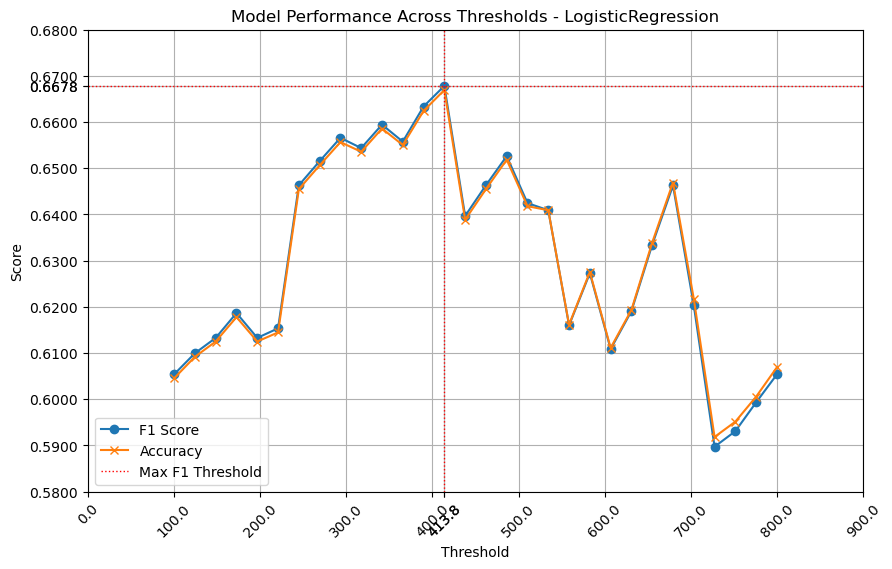

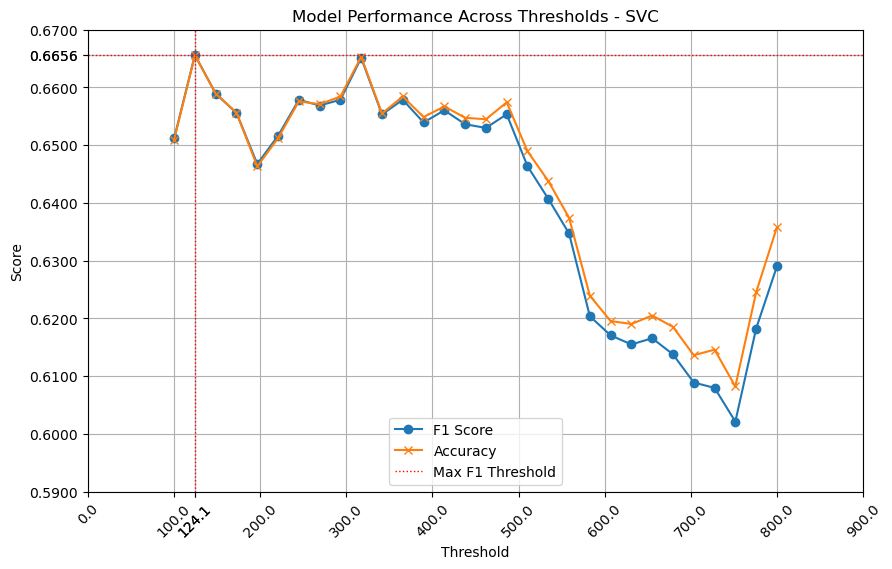

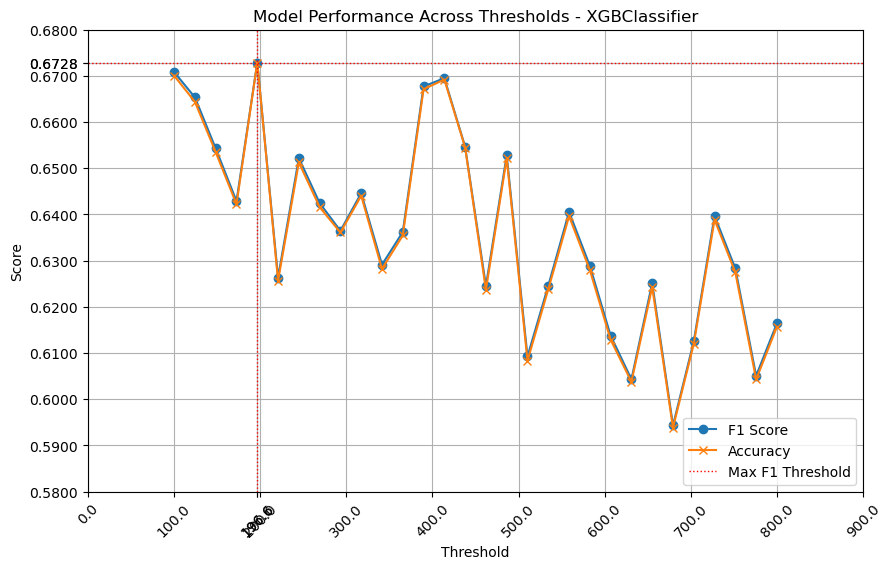

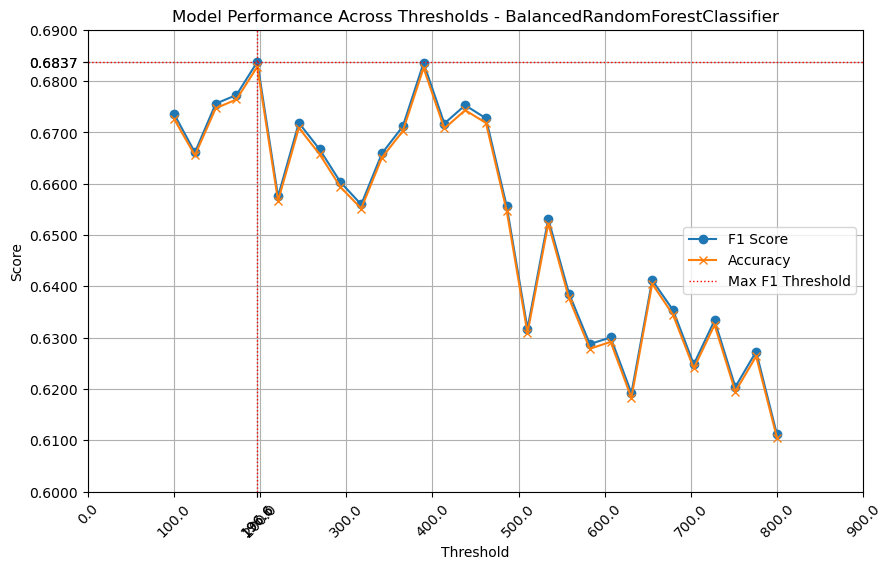

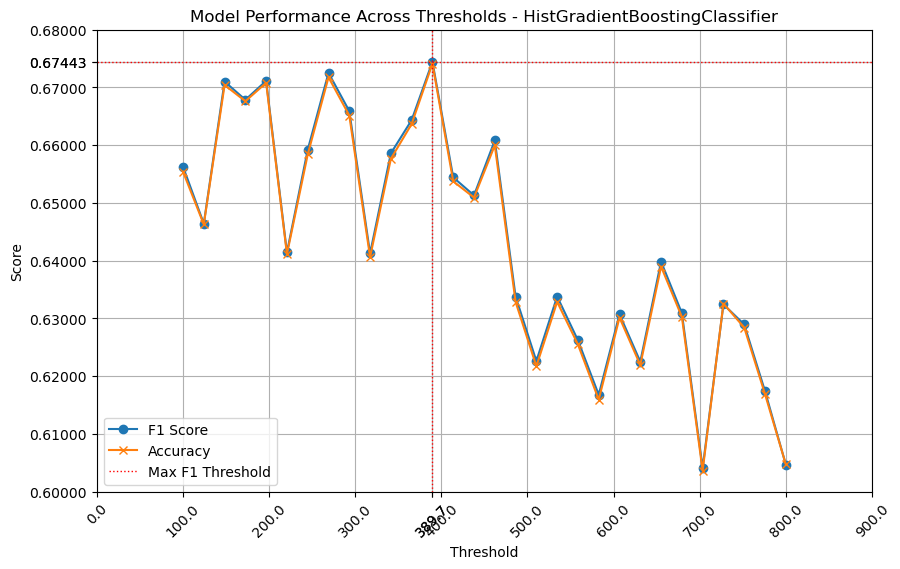

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
balanced_accuracy_score, accuracy_score, f1_score, 
roc_auc_score, log_loss, classification_report, confusion_matrix
)
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import PowerTransformer

# Paths to data
prepared_data_path = "./outputs/prepared_data.csv"


def create_label(prepared_data_path, lsoa_planning_path, use_percentile=False, threshold=0.25, multi=False, num_classes=4):
    prepared_data = pd.read_csv(prepared_data_path)
    
    if use_percentile:
        top_25_threshold = prepared_data["gentrification_score"].quantile(1 - threshold)
        bottom_25_threshold = prepared_data["gentrification_score"].quantile(threshold)

        # Binarize gentrification score: 1 if score > top 25th percentile, 0 if score < bottom 25th percentile
        prepared_data["gentrification_binary"] = np.where(
            prepared_data["gentrification_score"] > top_25_threshold,
            1,
            np.where(prepared_data["gentrification_score"] < bottom_25_threshold, 0, np.nan)
        )

        # Drop rows with NaN values in the binary gentrification score
        prepared_data = prepared_data.dropna(subset=["gentrification_binary"])

    if multi:
        thresholds = np.percentile(prepared_data["gentrification_score"], np.linspace(0, 100, num_classes + 1))
        prepared_data["gentrification_class"] = np.digitize(prepared_data["gentrification_score"], thresholds[1:-1], right=True)

    return prepared_data

def transform_predictors(merged_data, all_predictors, log_transform=False, cube_root=False, inverse_sine=False, pt_transform=False):
    # Apply log1p transformation
    if log_transform:
        for predictor in all_predictors:
            merged_data[predictor] = np.log1p(merged_data[predictor])

    if cube_root:
        for predictor in all_predictors:
            merged_data[predictor] = np.cbrt(merged_data[predictor])

    if inverse_sine:
        for predictor in all_predictors:
            merged_data[predictor] = np.arcsinh(merged_data[predictor])

    # Apply Box-Cox or Yeo-Johnson transformation
    pt = PowerTransformer(method="yeo-johnson", standardize=True)

    if pt_transform:
        for predictor in all_predictors:
            merged_data[predictor] = pt.fit_transform(merged_data[[predictor]])

    return merged_data

def evaluate_model(merged_data, all_predictors, target, model, thresholds):
    f1_scores = []
    accuracies = []
    roc_aucs = []
    
    for threshold in thresholds:
        threshold = int(threshold)
        data = create_label(prepared_data_path, lsoa_planning_path, use_percentile=True)
        
        change_predictors = [col for col in data.columns if col.endswith(f"{threshold}")]
        planning_predictors = [col for col in lsoa_planning.columns if not col.isupper()]
        all_predictors = change_predictors + planning_predictors
        # target = "gentrification_binary"
        
        data = transform_predictors(data, all_predictors, log_transform=False, cube_root=False, inverse_sine=False, pt_transform=True)
        
        X = data[all_predictors]
        y = data[target]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        f1 = f1_score(y_test, y_pred, average='weighted')
        accuracy = balanced_accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        f1_scores.append(f1)
        accuracies.append(accuracy)
        roc_aucs.append(roc_auc)
        
    return f1_scores, accuracies, roc_aucs, X, y

# Define thresholds for ablation study
thresholds = np.linspace(100, 800, 30)

# Choose model
# model = LogisticRegression(max_iter=1000, class_weight="balanced")
# model = BalancedRandomForestClassifier(n_estimators=500)
# model = HistGradientBoostingClassifier(class_weight="balanced")
models = [
    LogisticRegression(max_iter=1000, class_weight="balanced"),
    SVC(class_weight="balanced", probability=True),
    XGBClassifier(scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1], n_jobs=-1),
    BalancedRandomForestClassifier(n_estimators=500),
    HistGradientBoostingClassifier(class_weight="balanced")
]

for model in models:
    # Evaluate model across thresholds
    target = "gentrification_binary"
    f1_scores, accuracies, aucs, X, y = evaluate_model(merged_data, change_predictors, target, model, thresholds)
    
    # Plot the results
    # Find the threshold that maximizes the F1 score
    max_f1_index = np.argmax(f1_scores)
    max_f1_threshold = thresholds[max_f1_index]
    max_f1_score = f1_scores[max_f1_index]
    
    # Find the threshold that maximizes the Accuracy
    max_acc_index = np.argmax(accuracies)
    max_acc_threshold = thresholds[max_acc_index]
    max_acc_score = accuracies[max_acc_index]
    
    # Find the threshold that maximizes the AUC
    max_auc_index = np.argmax(aucs)
    max_auc_threshold = thresholds[max_auc_index]
    max_auc_score = aucs[max_auc_index]
    
    # print(f"The threshold that maximizes the F1 score is: {max_f1_threshold} with an F1 score of {max_f1_score}")
    # print(f"The threshold that maximizes the Accuracy is: {max_acc_threshold} with an Accuracy of {max_acc_score}")
    # print(f"The threshold that maximizes the AUC is: {max_auc_threshold} with an AUC of {max_auc_score}")
    
    model_name = type(model).__name__
    output_image_path = f"./outputs/ablation-{model_name}.png"
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
    plt.plot(thresholds, accuracies, marker='x', label='Accuracy')
    # plt.plot(thresholds, aucs, marker='2', label='ROC-AUC')
    plt.axvline(x=max_f1_threshold, color='red', linestyle='dotted', linewidth=1, label='Max F1 Threshold')
    plt.axhline(y=max_f1_score, color='red', linestyle='dotted', linewidth=1)
    # plt.axvline(x=max_acc_threshold, color='blue', linestyle='dotted', linewidth=1, label='Max Accuracy Threshold')
    # plt.axhline(y=max_acc_score, color='blue', linestyle='dotted', linewidth=1)
    plt.xticks(list(plt.xticks()[0]) + [max_f1_threshold, max_f1_threshold])
    plt.yticks(list(plt.yticks()[0]) + [max_f1_score, max_f1_score])
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Model Performance Across Thresholds - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig(output_image_path, bbox_inches="tight", transparent=True, dpi=500)
    plt.show()


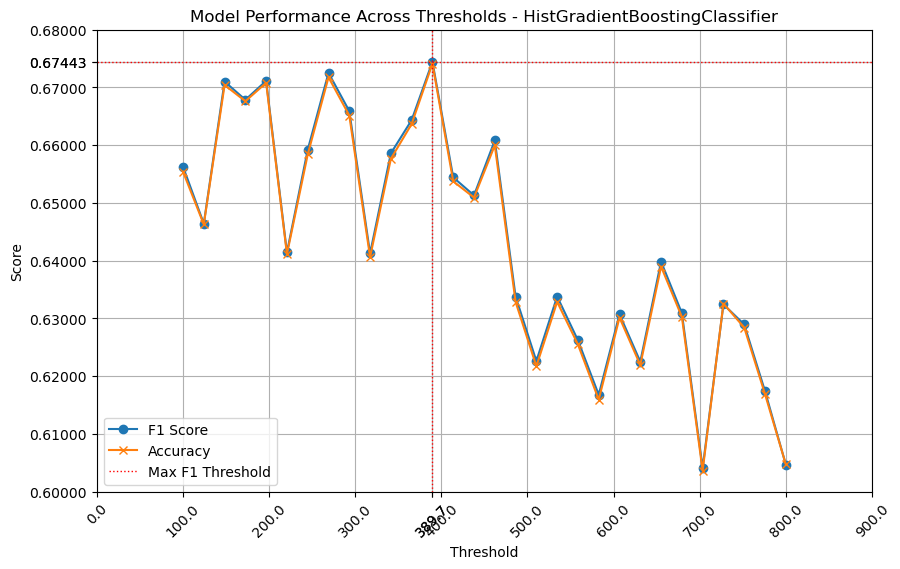

In [49]:
# Find the threshold that maximizes the F1 score
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
max_f1_score = f1_scores[max_f1_index]

# Find the threshold that maximizes the Accuracy
max_acc_index = np.argmax(accuracies)
max_acc_threshold = thresholds[max_acc_index]
max_acc_score = accuracies[max_acc_index]

# print(f"The threshold that maximizes the F1 score is: {max_f1_threshold} with an F1 score of {max_f1_score}")
# print(f"The threshold that maximizes the Accuracy is: {max_acc_threshold} with an Accuracy of {max_acc_score}")

model_name = type(model).__name__
output_image_path = f"./outputs/ablation-{model_name}.png"

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.plot(thresholds, accuracies, marker='x', label='Accuracy')
plt.axvline(x=max_f1_threshold, color='red', linestyle='dotted', linewidth=1, label='Max F1 Threshold')
plt.axhline(y=max_f1_score, color='red', linestyle='dotted', linewidth=1)
# plt.axvline(x=max_acc_threshold, color='blue', linestyle='dotted', linewidth=1, label='Max Accuracy Threshold')
# plt.axhline(y=max_acc_score, color='blue', linestyle='dotted', linewidth=1)
plt.xticks(list(plt.xticks()[0]) + [max_f1_threshold, max_acc_threshold])
plt.yticks(list(plt.yticks()[0]) + [max_f1_score, max_f1_score])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'Model Performance Across Thresholds - {model_name}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# plt.savefig(output_image_path, bbox_inches="tight", transparent=True, dpi=500)
plt.show()


In [36]:
pd.DataFrame({"f1":f1_scores, "acc": accuracies, "auc": aucs, "thresholds": thresholds})

,f1,acc,auc,thresholds
0,0.66,0.66,0.72,100.00
1,0.65,0.65,0.71,124.14
2,0.67,0.67,0.74,148.28
3,0.67,0.67,0.73,172.41
4,0.67,0.67,0.73,196.55
5,0.64,0.64,0.70,220.69
6,0.66,0.66,0.71,244.83
7,0.67,0.67,0.73,268.97
8,0.67,0.67,0.72,293.10
9,0.64,0.64,0.69,317.24


In [12]:
change_predictors = [col for col in merged_data.columns if col.endswith(f"{int(max_f1_threshold)}")]
change_predictors

['filtered_changes_band_1_threshold_413',
 'filtered_changes_band_2_threshold_413',
 'filtered_changes_band_3_threshold_413',
 'filtered_changes_band_4_threshold_413',
 'filtered_changes_band_5_threshold_413',
 'filtered_changes_band_6_threshold_413',
 'filtered_changes_band_7_threshold_413',
 'filtered_changes_band_8_threshold_413',
 'filtered_changes_band_9_threshold_413',
 'filtered_changes_band_10_threshold_413',
 'filtered_changes_band_11_threshold_413']

In [14]:
max_f1_threshold, int(max_f1_threshold)

(413.7931034482759, 413)

In [56]:
from lazypredict.Supervised import LazyClassifier


threshold = f"{int(max_f1_threshold)}"
data = create_label(prepared_data_path, lsoa_planning_path, use_percentile=True)

change_predictors = [col for col in data.columns if col.endswith(f"{threshold}")]
planning_predictors = [col for col in lsoa_planning.columns if not col.isupper()]
all_predictors = change_predictors + planning_predictors
target = "gentrification_binary"

data = transform_predictors(data, all_predictors, pt_transform=True)

X = data[all_predictors]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
model_dictionary = clf.provide_models(X_train, X_test, y_train, y_test)

models

100%|██████████| 29/29 [00:01<00:00, 16.87it/s]

[LightGBM] [Info] Number of positive: 918, number of negative: 895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3994
[LightGBM] [Info] Number of data points in the train set: 1813, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506343 -> initscore=0.025374
[LightGBM] [Info] Start training from score 0.025374


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.68,0.68,0.68,0.68,0.35
LGBMClassifier,0.67,0.67,0.67,0.67,0.09
NuSVC,0.67,0.67,0.67,0.67,0.15
ExtraTreesClassifier,0.67,0.67,0.67,0.67,0.17
LinearSVC,0.66,0.66,0.66,0.66,0.08
RidgeClassifier,0.66,0.66,0.66,0.66,0.01
RidgeClassifierCV,0.66,0.66,0.66,0.66,0.01
CalibratedClassifierCV,0.66,0.66,0.66,0.66,0.03
LinearDiscriminantAnalysis,0.66,0.66,0.66,0.66,0.01


In [57]:
model_dictionary.keys()

dict_keys(['AdaBoostClassifier', 'BaggingClassifier', 'BernoulliNB', 'CalibratedClassifierCV', 'DecisionTreeClassifier', 'DummyClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'GaussianNB', 'KNeighborsClassifier', 'LabelPropagation', 'LabelSpreading', 'LinearDiscriminantAnalysis', 'LinearSVC', 'LogisticRegression', 'NearestCentroid', 'NuSVC', 'PassiveAggressiveClassifier', 'Perceptron', 'QuadraticDiscriminantAnalysis', 'RandomForestClassifier', 'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier', 'SVC', 'XGBClassifier', 'LGBMClassifier'])

In [58]:
change_predictors

['filtered_changes_band_1_threshold_389',
 'filtered_changes_band_2_threshold_389',
 'filtered_changes_band_3_threshold_389',
 'filtered_changes_band_4_threshold_389',
 'filtered_changes_band_5_threshold_389',
 'filtered_changes_band_6_threshold_389',
 'filtered_changes_band_7_threshold_389',
 'filtered_changes_band_8_threshold_389',
 'filtered_changes_band_9_threshold_389',
 'filtered_changes_band_10_threshold_389',
 'filtered_changes_band_11_threshold_389']

In [60]:
model_dictionary['RandomForestClassifier']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['filtered_changes_band_1_threshold_389',
       'filtered_changes_band_2_threshold_389',
       'filtered_changes_band_3_threshold_389',
       'filtered_changes_band_4_threshold_389',
       'filtered_changes_band_5_threshold_389',
       'filtered_changes_band...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index([], dtype='object')),
                                                 ('categorical_high',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  Index([], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [68]:
model_dictionary['RandomForestClassifier'].named_steps['classifier']

RandomForestClassifier(random_state=42)

In [71]:
import pandas as pd

# Dictionary to hold the feature importances or coefficients for each model
feature_importances = {}

# Example feature names - replace this with the actual feature names from your pipeline
feature_names = X.columns

# Iterate through the models
for model_name in ['RandomForestClassifier', 'ExtraTreesClassifier', 'LogisticRegression', 'RidgeClassifierCV']:
    # Access the trained model inside the pipeline
    model = model_dictionary[model_name].named_steps['classifier']
    
    if hasattr(model, 'feature_importances_'):
        # If the model has feature importances (e.g., RandomForestClassifier, ExtraTreesClassifier)
        feature_importances[model_name] = model.feature_importances_
    
    elif hasattr(model, 'coef_'):
        # If the model has coefficients (e.g., LogisticRegression)
        feature_importances[model_name] = model.coef_.flatten()  # Flatten in case of a 2D array
    
    else:
        print(f"Model {model_name} does not support feature importances or coefficients extraction.")

importance_df = pd.DataFrame(feature_importances, index=feature_names)
importance_df.sort_values('LogisticRegression', ascending=False)


,RandomForestClassifier,ExtraTreesClassifier,LogisticRegression,RidgeClassifierCV
filtered_changes_band_8_threshold_389,0.10,0.08,0.85,0.36
filtered_changes_band_11_threshold_389,0.08,0.07,0.47,0.20
Central_Activities_Zone,0.01,0.02,0.43,0.09
filtered_changes_band_6_threshold_389,0.07,0.06,0.20,0.08
Article_4_Directions_Office_to_Residential,0.03,0.04,0.15,0.07
filtered_changes_band_2_threshold_389,0.07,0.06,0.11,0.05
Site_Allocations,0.03,0.04,0.09,0.03
filtered_changes_band_1_threshold_389,0.04,0.05,0.08,0.03
filtered_changes_band_3_threshold_389,0.06,0.06,0.08,0.03
Housing_Zones,0.01,0.02,0.02,0.01


In [26]:
for threshold in np.linspace(100, 800, 30):
    print(int(threshold))

100
124
148
172
196
220
244
268
293
317
341
365
389
413
437
462
486
510
534
558
582
606
631
655
679
703
727
751
775
800
